In [1]:
import numpy as np
import random
import os, errno
import sys
from tqdm import trange
from copy import deepcopy

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

import pandas as pd
import math

#https://github.com/lkulowski/LSTM_encoder_decoder/blob/master/code/

In [2]:
torch.cuda.is_available()

True

In [3]:
data_folder = "C:\\Users\\spars\\Documents\\Master\\JHU\TML\\HomePriceBeastNew\\"

In [4]:
with open(f"{data_folder}all_model_data.npy", 'rb') as f:
    # Format of input x: (J, batch_size, num_features(k)), y: (H, batch_size, 1)
    X_train = np.load(f, allow_pickle=True)
    y_train = np.load(f, allow_pickle=True)
    X_test = np.load(f, allow_pickle=True)
    y_test = np.load(f, allow_pickle=True)

In [5]:
with open(f"{data_folder}all_model_labels_mapping.npy", 'rb') as f:
    train_label = np.load(f, allow_pickle=True)
    test_label = np.load(f, allow_pickle=True)

In [6]:
print(X_train.shape)
print(y_train.shape)

(5, 218236, 92)
(4, 218236, 1)


In [7]:
np.nan_to_num(X_train,copy=False)
np.nan_to_num(y_train,copy=False)
np.nan_to_num(X_test,copy=False)
np.nan_to_num(y_test,copy=False)

array([[[449.],
        [437.],
        [427.],
        ...,
        [106.],
        [105.],
        [107.]],

       [[437.],
        [427.],
        [418.],
        ...,
        [105.],
        [107.],
        [108.]],

       [[427.],
        [418.],
        [409.],
        ...,
        [107.],
        [108.],
        [109.]],

       [[418.],
        [409.],
        [410.],
        ...,
        [108.],
        [109.],
        [108.]]])

In [8]:
X_train_torch = torch.from_numpy(X_train).type(torch.Tensor).cuda()
Y_train_torch = torch.from_numpy(y_train).type(torch.Tensor).cuda()

X_test_torch = torch.from_numpy(X_test).type(torch.Tensor).cuda()
Y_test_torch = torch.from_numpy(y_test).type(torch.Tensor).cuda()

In [9]:
class inp_layer_norm(nn.Module):
    def __init__(self,input_size):
        '''
        : param input_size:     the number of features in the input X
        '''
        
        super(inp_layer_norm, self).__init__()
        
        self.layerNorm = nn.LayerNorm(input_size)
        
    def forward(self,x_input):
        n_input = self.layerNorm(x_input)
        
        return n_input

In [10]:
class lstm_final_output(nn.Module):
    '''Takes the final decoder output and the output a single feature.'''
    def __init__(self, input_size, output_size):
        '''
        : param input_size:     the number of features in the input X
        : param output_size:    the number of features in the output Y
        '''
        
        super(lstm_final_output, self).__init__()
        self.input_size = input_size
        self.output_size = output_size 
        
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x_input):
        
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        output = self.linear(x_input.squeeze(0))     
        
        return output

    
class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, dropout = 0.0, num_layers = 1):
        
        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
       
        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, dropout=dropout,
                            num_layers = num_layers)
        
        
    def forward(self, x_input):
        
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence 
        '''

        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        
        '''
        initialize hidden state
        : param batch_size:    x_input.shape[1]
        : return:              zeroed hidden state and cell state 
        '''
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size, hidden_size, dropout=0.0, num_layers = 1):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, dropout = dropout,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.linear(lstm_out.squeeze(0))     
        
        return output, self.hidden

class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size, hidden_size, output_size, dropout = 0.0, num_layers=1):

        '''
        : param input_size:     the number of expected features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param output_size:    the number of features in the output Y
        '''

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.layer_norm = inp_layer_norm(input_size = input_size)
        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size, dropout=dropout, num_layers=num_layers)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size, dropout=dropout, num_layers=num_layers)
        self.outputter = lstm_final_output(input_size = input_size, output_size = output_size)

    def train_model(self, input_tensor, target_tensor, n_epochs, target_len, batch_size, learning_rate = 0.01):
        
        '''
        train lstm encoder-decoder
        
        : param input_tensor:              input data with shape (seq_len, # in batch, number features); PyTorch tensor    
        : param target_tensor:             target data with shape (seq_len, # in batch, number features); PyTorch tensor
        : param n_epochs:                  number of epochs 
        : param target_len:                number of values to predict 
        : param batch_size:                number of samples per gradient update
        : param learning_rate:             float >= 0; learning rate
        : return losses:                   array of loss function for each epoch
        '''
        
        # initialize array of losses 
        losses = np.full(n_epochs, np.nan)
        losses_per_horizon = np.full((n_epochs, target_len), np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                
                batch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0

                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, target_batch.shape[2]).cuda()

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()
                    
                    #Layer normalization
                    input_batch = self.layer_norm(input_batch)

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    # predict recursively
                    for t in range(target_len): 
                        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                        outputs[t] = self.outputter(decoder_output)
                        decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    loss_per_horizon = np.full(target_len, np.nan)
                    for t in range(target_len): 
                        loss_per_horizon[t] = criterion(outputs[t], target_batch[t])
                    batch_loss += loss.item()
                    
                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss
                for t in range(target_len):
                    losses_per_horizon[it][t] = loss_per_horizon[t]
                # progress bar 
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))
                    
        return losses, losses_per_horizon

    def predict(self, input_tensor, target_len):
        
        '''
        : param input_tensor:      input data (seq_len, input_size); PyTorch tensor 
        : param target_len:        number of target values to predict 
        : return np_outputs:       np.array containing predicted values; prediction done recursively 
        '''

        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, self.output_size).cuda()

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = self.outputter(decoder_output)
            decoder_input = decoder_output
            
        np_outputs = outputs.cpu().detach().numpy()
        
        return np_outputs

In [11]:
def plot_train_test_results(lstm_model, Xtrain, Ytrain, Xtest, Ytest, num_rows = 4):
    '''
    plot examples of the lstm encoder-decoder evaluated on the training/test data

    : param lstm_model: trained lstm encoder-decoder
    : param Xtrain: np.array of windowed training input data
    : param Ytrain: np.array of windowed training target data
    : param Xtest: np.array of windowed test input data
    : param Ytest: np.array of windowed test target data 
    : param num_rows: number of training/test examples to plot
    '''
    offset = random.randint(5, Ytest.shape[1]-num_rows)
    # input window size
    iw = Xtrain.shape[0]
    ow = Ytest.shape[0]

    # figure setup 
    num_cols = 2
    num_plots = num_rows * num_cols

    fig, ax = plt.subplots(num_rows, num_cols, figsize = (13, 15))

    # plot training/test predictions
    for ii in range(num_rows):
        # train set
        X_train_plt = Xtrain[:, offset+ii, :]
        Y_train_pred = lstm_model.predict(torch.from_numpy(X_train_plt).type(torch.Tensor).cuda(), target_len = ow)

        ax[ii, 0].plot(np.arange(0, iw), Xtrain[:, offset+ii, 0], 'k', linewidth = 2, label = 'Input')
        ax[ii, 0].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, offset+ii, 0]], Ytrain[:, offset+ii, 0]]),
                                                                 color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
        ax[ii, 0].plot(np.arange(iw - 1, iw + ow),        np.concatenate([[Xtrain[-1, offset+ii, 0]], Y_train_pred[:, 0]]),
                                                                 color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
        ax[ii, 0].set_xlim([0, iw + ow - 1])
        ax[ii, 0].set_xlabel('$t$')
        ax[ii, 0].set_ylabel('$y$')

        # test set
        X_test_plt = Xtest[:, offset+ii, :]
        Y_test_pred = lstm_model.predict(torch.from_numpy(X_test_plt).type(torch.Tensor).cuda(), target_len = ow)
        ax[ii, 1].plot(np.arange(0, iw), Xtest[:, offset+ii, 0], 'k', linewidth = 2, label = 'Input')
        ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, offset+ii, 0]], Ytest[:, offset+ii, 0]]),
                                                                 color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
        ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, offset+ii, 0]], Y_test_pred[:, 0]]),
                                                                 color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
        ax[ii, 1].set_xlim([0, iw + ow - 1])
        ax[ii, 1].set_xlabel('$t$')
        ax[ii, 1].set_ylabel('$y$')

        if ii == 0:
                ax[ii, 0].set_title('Train')

                ax[ii, 1].legend(bbox_to_anchor=(1, 1))
                ax[ii, 1].set_title('Test')

    plt.suptitle('LSTM Encoder-Decoder Predictions', x = 0.445, y = 1.)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.95)
    plt.show()
#         plt.savefig('plots/predictions.png')
    plt.close() 

    return 

In [12]:
def get_prediction_result(X_test, Ytest, test_label, lstm_model):
    labels_county = test_label[0,:,0]
    labels_period = test_label[1,:,0]
    labels_state = test_label[2,:,0]
    ow = Ytest.shape[0]
    Y_test_pred = np.array([lstm_model.predict(torch.from_numpy(X_test[:,ii,:]).type(torch.Tensor).cuda(), target_len = ow) for ii in range(X_test.shape[1])])
    df = pd.DataFrame()
    df["county_name"] = labels_county
    df["period_begin"] = labels_period
    df["state_code"] = labels_state
    
    for ix in range(ow):
        df[f"y_{ix+1}"] = Ytest[ix,:,0]
        df[f"y_hat_{ix+1}"] = Y_test_pred[:,ix,0]
    
    return df

In [13]:
def plot_loss_values(loss, losses_per_horizon):
    n_epochs = len(loss)
    target_len = losses_per_horizon.shape[1]
    fig, ax = plt.subplots(2, 1, figsize = (8,8))
    col_index = ['k', 'g', 'r', 'b', 'm']
    for ii in range(target_len + 1):
        if ii == 0:
            ax[ii].plot(np.arange(1, n_epochs+1), loss, col_index[ii], linewidth = 2, label = 'Overall Loss')
            ax[ii].legend(bbox_to_anchor=(1, 1))
            ax[ii].set_title('Overall Loss')
            ax[ii].set_xlabel('Epochs')
            ax[ii].set_ylabel('Training Loss')
        else:
            ax[1].plot(np.arange(1, n_epochs+1), losses_per_horizon[:, ii-1], col_index[ii], linewidth = 1, label = f"Horizon {ii} loss")
            ax[1].legend(bbox_to_anchor=(1, 1))
            ax[1].set_title(f"Horizon loss")
            ax[1].set_xlabel('Epochs')
            ax[1].set_ylabel('Training Loss')
    plt.suptitle('Loss curves', x = 0.445, y = 1.)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.95)
    plt.show()
    #   plt.savefig('plots/predictions.png')
    plt.close() 

In [14]:
# H = 3
# model = lstm_seq2seq(input_size = X_train_torch.shape[2], hidden_size = 30, output_size = 1).cuda()
# loss, losses_per_horizon = model.train_model(X_train_torch, 
#                          Y_train_torch, 
#                          n_epochs = 10, 
#                          target_len = (H+1), 
#                          batch_size = 20000,
#                          learning_rate = 0.02)

In [15]:
# plot_loss_values(loss, losses_per_horizon)

In [16]:
# df = get_prediction_result(X_test, y_test, test_label, model)

In [17]:
# def plot_mape_dist(df):
#     for i in range(1,5):
#         df[f"mape_{i}"] = math.abs(df[f"y_hat_{i}"] - df[f"y_{i}"])/(df[f"y_{i}"] + 0.00001)

In [18]:
# plot predictions on train/test data
# plot_train_test_results(model, 
#                          X_train, 
#                          y_train, 
#                          X_test, 
#                          y_test)

# plt.close('all')

#Goals :
3) Get MAPE plots. 
1) Make the model complex. 
4) Create a grid search for params and pick best model. 
5) Repeat this for median sale price without supply. 

-------------------------------------
HIDDEN SIZE 40 : NUM LAYERS : 2 : LEARNING RATE : 0.02 : DROP OUT : 0.0


100%|███████████████████████████████████████████████████████████████| 300/300 [54:37<00:00, 10.92s/it, loss=148402.433]


New best model found


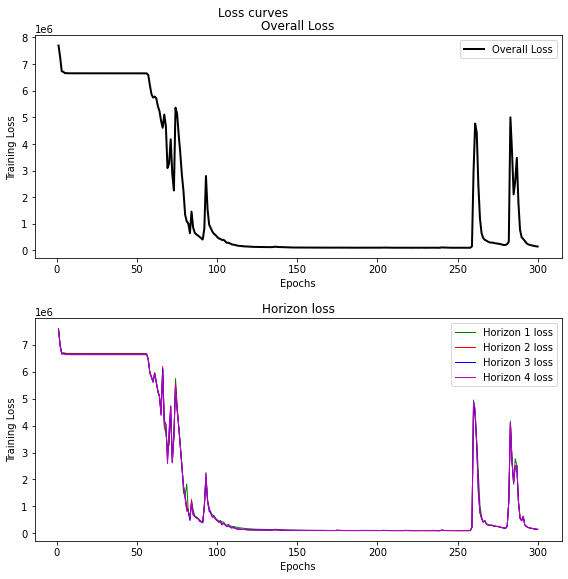

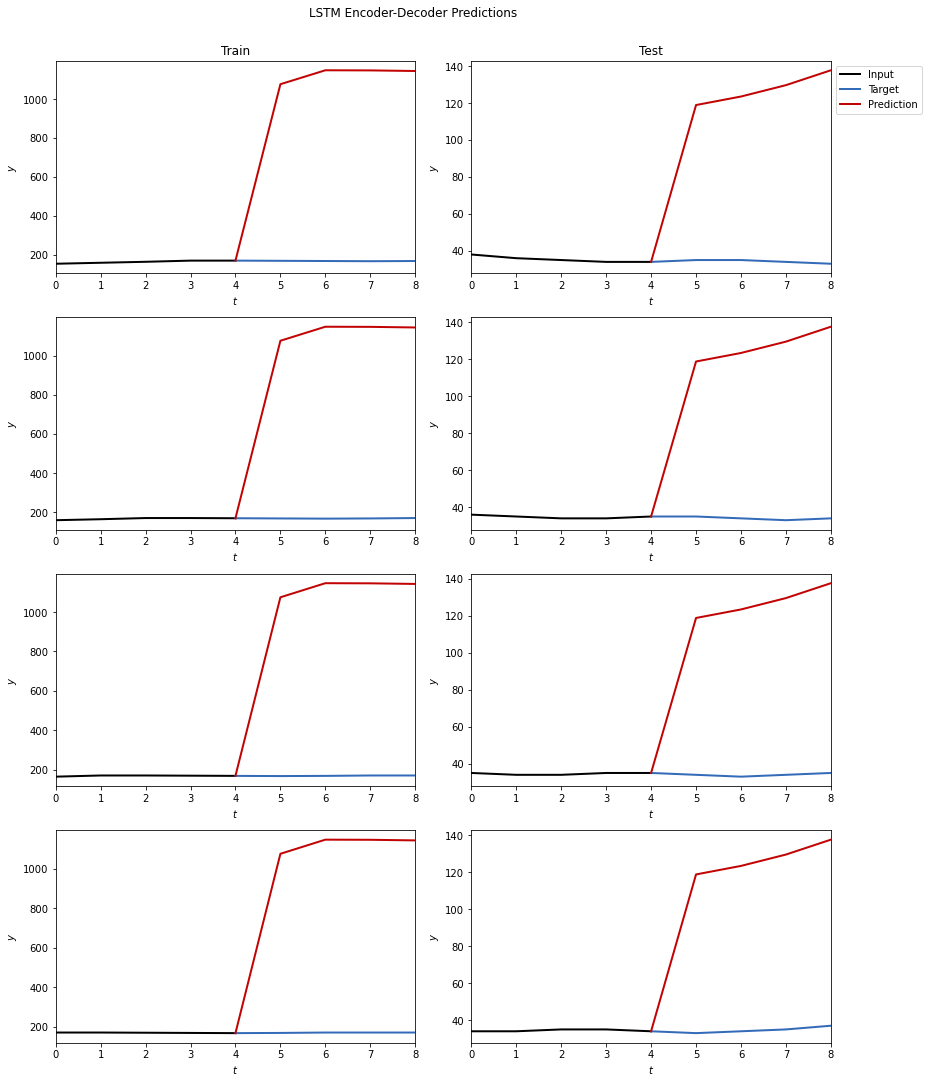

-------------------------------------


In [19]:
H=3
hidden_sizes = [40]
layers = [2]
learning_rates = [0.02]
dropouts = [0.0]
n_epochs = 300
batch_size = 20000

best_model = None
best_loss = float("inf")
best_losses_per_horizon = None

for h in hidden_sizes:
    for l in layers: 
        for lr in learning_rates:
            for do in dropouts:
                print("-------------------------------------")
                print(f"HIDDEN SIZE {h} : NUM LAYERS : {l} : LEARNING RATE : {lr} : DROP OUT : {do}")

                model = lstm_seq2seq(input_size = X_train_torch.shape[2], hidden_size = h, dropout = do,
                                     output_size = 1, num_layers=l).cuda()
                loss, losses_per_horizon = model.train_model(X_train_torch, 
                                         Y_train_torch, 
                                         n_epochs = n_epochs, 
                                         target_len = (H+1), 
                                         batch_size = batch_size,
                                         learning_rate = lr)
                
                if loss[n_epochs - 1] < best_loss:
                    print("New best model found")
                    best_model = model
                    best_loss = loss[n_epochs - 1]
                    best_losses_per_horizon = losses_per_horizon
                    
                plot_loss_values(loss, losses_per_horizon)


                # plot predictions on train/test data
                plot_train_test_results(model, 
                                         X_train, 
                                         y_train, 
                                         X_test, 
                                         y_test)
                
                
                print("-------------------------------------")
torch.save(best_model.state_dict(), './inv_model_new.pth')

#Final Model Train for best model. - HIDDEN SIZE 30 : NUM LAYERS : 8 : LEARNING RATE : 0.01 - Result on 300/300 [2:43:01<00:00, 32.61s/it, loss=56721.818]

In [23]:
# torch.save(best_model.state_dict(), './inv_model.pth')

#TODO : 
1) Predict and collect results and MAPE. 
2) Create counterfactual and get model predictions

In [20]:
with open(f"{data_folder}post_covid_inv_data.npy", 'rb') as f:
    X_post_covid = np.load(f, allow_pickle=True)
    y_post_covid = np.load(f, allow_pickle=True)
    
with open(f"{data_folder}post_covid_inv_labels_mapping.npy", 'rb') as f:
    post_covid_label = np.load(f, allow_pickle=True)

In [21]:
def get_counterfactual_inventory(X_post_covid, post_covid_label, lstm_model):
    labels_county = post_covid_label[0,:,0]
    labels_period = post_covid_label[1,:,0]
    labels_state = post_covid_label[2,:,0]
    labels_fips = [c + ',' + s for c,s in zip(list(labels_county), list(labels_state))]
    labels_fips_unique = np.unique(labels_fips)

    column_names = ["state_code", "county_name", "period_begin", 'inventory']
    
    counterfactual_df = pd.DataFrame()
    
    for fips in labels_fips_unique:
#         print(f"Computing for fips {fips}")
        indices = [i for i, x in enumerate(labels_fips) if x == fips]

        periods = labels_period[indices]
        len_periods = len(periods)
#         print(f"len(periods) : {len(periods)}")
        start_period_index = min(indices)
#         print(f"start_period_index : {start_period_index}")
        y_res = lstm_model.predict(torch.from_numpy(X_post_covid[:,start_period_index,:]).type(torch.Tensor).cuda(), target_len = len_periods)

        df2 = pd.DataFrame()
        df2['inventory'] = list(y_res)
        df2['period_begin'] = labels_period[start_period_index: start_period_index+len_periods]
        df2['state_code'] = labels_state[start_period_index]
        df2['county_name'] = labels_county[start_period_index]
        
        counterfactual_df = counterfactual_df.append(df2, ignore_index = True)

    return counterfactual_df

In [22]:
def plot_mape_dist(predicted_df, expected_df):
    predicted_df = predicted_df[~expected_df['inventory'].isnull()]
    expected_df = expected_df[~expected_df['inventory'].isnull()]
    expected_df.rename(columns={"inventory": "actual_inventory"},inplace=True)
    result = pd.merge(predicted_df, expected_df, on=['county_name', 'state_code', 'period_begin'])
    result['inventory'] = [x[0] for x in result['inventory'].values]
    
    result['MAPE'] = 100*(abs(result["actual_inventory"] - result["inventory"]) / (abs(result["actual_inventory"])+0.1))
    county_mape = result.groupby(['county_name', 'state_code']).agg({'MAPE':'mean'})
    county_mape = county_mape.reset_index()
    
    ax = county_mape['MAPE'].hist(bins=30, range=(0,200))
    
    ax.set_xlabel("MAPE")
    ax.set_ylabel("Frequency")
    ax.set_title("MAPE Histogram on Test data for Inventory")
    return county_mape

In [73]:
#HIDDEN SIZE 10 : NUM LAYERS : 2 : LEARNING RATE : 0.02 : DROP OUT : 0.0
best_model = lstm_seq2seq(input_size = X_train_torch.shape[2], hidden_size = 40, dropout = 0.0,
                     output_size = 1, num_layers=2).cuda()
best_model.load_state_dict(torch.load('./inv_model.pth'))

<All keys matched successfully>

In [23]:
np.nan_to_num(X_post_covid,copy=False)
np.nan_to_num(X_test,copy=False)

array([[[491.,  44.,  10., ...,   0.,   0.,   0.],
        [482.,  45.,  11., ...,   0.,   0.,   0.],
        [472.,  46.,  11., ...,   0.,   0.,   0.],
        ...,
        [118.,   2.,   1., ...,   0.,   0.,   1.],
        [116.,   3.,   1., ...,   0.,   0.,   1.],
        [113.,   4.,   1., ...,   0.,   0.,   1.]],

       [[482.,  45.,  11., ...,   0.,   0.,   0.],
        [472.,  46.,  11., ...,   0.,   0.,   0.],
        [464.,  47.,  11., ...,   0.,   0.,   0.],
        ...,
        [116.,   3.,   1., ...,   0.,   0.,   1.],
        [113.,   4.,   1., ...,   0.,   0.,   1.],
        [109.,   5.,   1., ...,   0.,   0.,   1.]],

       [[472.,  46.,  11., ...,   0.,   0.,   0.],
        [464.,  47.,  11., ...,   0.,   0.,   0.],
        [455.,  48.,  11., ...,   0.,   0.,   0.],
        ...,
        [113.,   4.,   1., ...,   0.,   0.,   1.],
        [109.,   5.,   1., ...,   0.,   0.,   1.],
        [107.,   6.,   2., ...,   0.,   0.,   1.]],

       [[464.,  47.,  11., ...,   0.,

In [ ]:
post_covid_expected_df = pd.read_csv(f"{data_folder}post_covid_subset_frame.csv")
post_covid_expected_df['period_begin'] = pd.to_datetime(post_covid_expected_df['period_begin'])
post_covid_predicted_df = get_counterfactual_inventory(X_post_covid, post_covid_label, best_model)

test_expected_df = pd.read_csv(f"{data_folder}test_subset_frame.csv")
test_expected_df['period_begin'] = pd.to_datetime(test_expected_df['period_begin'])
test_predicted_df = get_counterfactual_inventory(X_test, test_label, best_model)

In [ ]:
test_county_mape = plot_mape_dist(test_predicted_df, test_expected_df)

C:\ProgramData\Anaconda3\envs\TML\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


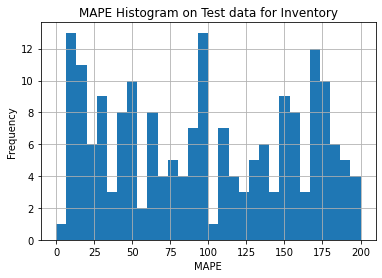

In [93]:
test_county_mape = plot_mape_dist(test_predicted_df, test_expected_df)

In [29]:
min(test_county_mape.MAPE)

C:\ProgramData\Anaconda3\envs\TML\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


array([0.05000792], dtype=float32)

In [30]:
max(test_county_mape.MAPE)

C:\ProgramData\Anaconda3\envs\TML\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([2014.102], dtype=float32)

#Read the best model and save the counterfactual and actual results for test and post covid. 

In [30]:
post_covid_predicted_df.to_csv(f"{data_folder}post_covid_predicted_df_inv.csv")
test_predicted_df.to_csv(f"{data_folder}test_predicted_df_inv.csv")

In [31]:
post_covid_expected_df.to_csv(f"{data_folder}post_covid_expected_df_inv.csv")
test_expected_df.to_csv(f"{data_folder}test_expected_df_inv.csv")

Index(['county_name', 'state_code', 'MAPE'], dtype='object')

In [44]:
test_expected_df.rename(columns={"inventory": "actual_inventory"},inplace=True)
result = pd.merge(test_predicted_df, test_expected_df, on=['county_name', 'state_code', 'period_begin'])
result["inventory"] = [x[0] for x in result["inventory"]]
result.to_csv(f"{data_folder}inv_test_pred_comparison.csv")
test_county_mape["MAPE"] = [x[0] for x in test_county_mape["MAPE"]]
test_county_mape.to_csv(f"{data_folder}inv_test_pred_comparison_MAPE.csv")

C:\ProgramData\Anaconda3\envs\TML\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


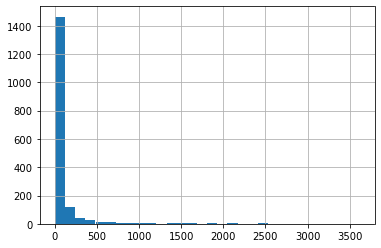

In [65]:
test_county_mape = plot_mape_dist(post_covid_predicted_df, post_covid_expected_df)

In [67]:
post_covid_expected_df.rename(columns={"inventory": "actual_inventory"},inplace=True)
result = pd.merge(post_covid_predicted_df, post_covid_expected_df, on=['county_name', 'state_code', 'period_begin'])
result["inventory"] = [x[0] for x in result["inventory"]]
result.to_csv(f"{data_folder}inv_post_covid_comparison.csv")

In [69]:
test_county_mape.sort_values('MAPE')

,county_name,state_code,MAPE
149,Brevard County,FL,0.050008
631,Hamilton County,OH,0.078673
1129,New Haven County,CT,0.129432
663,Hartford County,CT,0.132844
1499,Suffolk County,NY,0.149163
...,...,...,...
888,Lee County,GA,2411.158936
153,Brooks County,GA,2449.522949
108,Berrien County,GA,2516.868164
674,Henderson County,TN,2945.563232
